# Cross-species marker overlap analysis

## Import modules

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), 'bin'))
from cross_species_deg_overlap import * # custom module

import warnings
import matplotlib.pyplot as plt

from matplotlib import cm
from statistics import mean
from matplotlib import font_manager as fm, rcParams
from upsetplot import plot, from_contents, UpSet

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # suppress performance warnings

## Read in the data

In [2]:
# Define input file locations
file_locs = {"A. thaliana":"input/ath_log2FC0.5_FDR0.05.csv",\
             "T. aestivum":"input/tae_log2FC0.5_FDR0.05.csv",\
             "O. sativa":"input/osa_log2FC0.5_FDR0.05.csv", \
             "Z. mays":"input/zma_log2FC0.5_FDR0.05.csv"}
correspondance_file = "input/cell_type_correspondance_4_species.csv"
ath_alias_info_loc = "input/ath_gene_aliases.tsv"
tae_stability_info_loc = "input/stability_and_specificity_info.csv"

In [3]:
# Define output folder
output_folder = "output"

In [4]:
# Read in the input
species2df_dict = read_files(file_locs, sep=",")

# Arrange the input in a good format
species2gene2group_dict, _ = convert_df_to_dict(species2df_dict)

# Read in the cross-species cluster correspondance information
correspondance_dict = get_correspondance_dict(correspondance_file, sep=";")

# Read in Ath gene alias info and put in a dict
ath_alias_df = pd.read_csv(ath_alias_info_loc, sep="\t")
gene_to_alias_dict = dict(zip(ath_alias_df["locus_name"], ath_alias_df["symbol"]))
gene_to_alias_dict[""] = "" # map the empty string to an empty string

# Read in the wheat subgenome stability and specificity information
tae_stability_df = pd.read_csv(tae_stability_info_loc, sep=";")
gene_to_stability_dict = dict(zip(tae_stability_df["Gene"], tae_stability_df["Stability"]))
gene_to_specificity_dict = dict(zip(tae_stability_df["Gene"], tae_stability_df["Specificity"]))

## Plot the upsets for each individual tissue

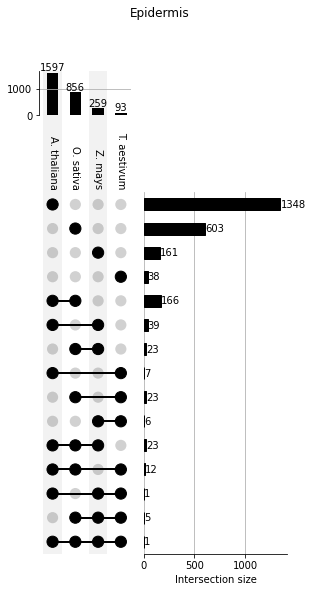

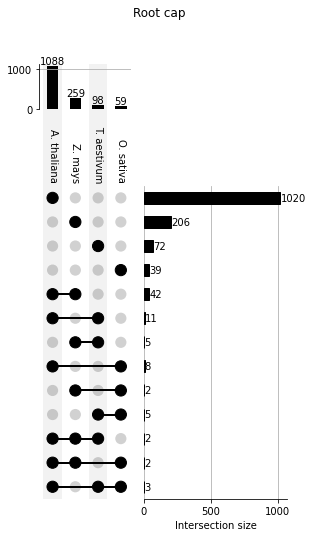

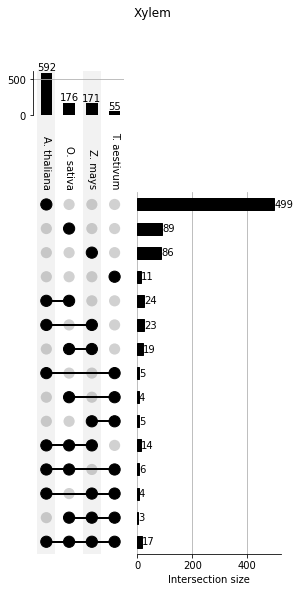

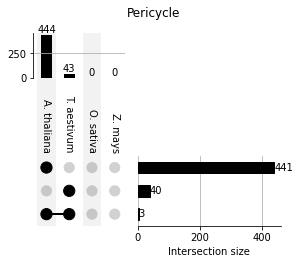

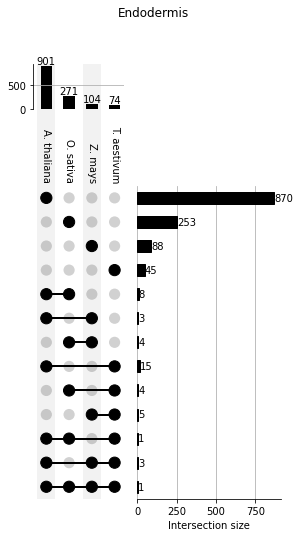

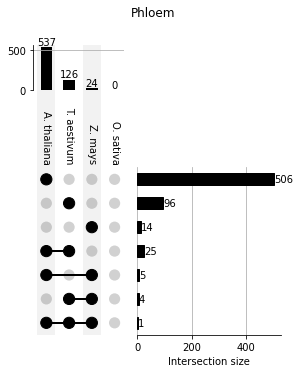

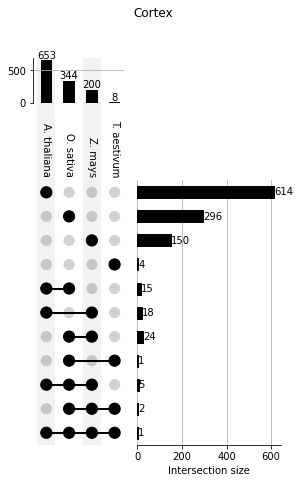

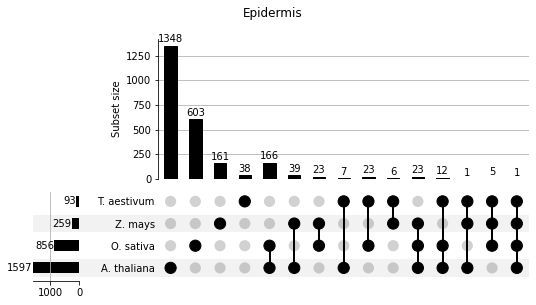

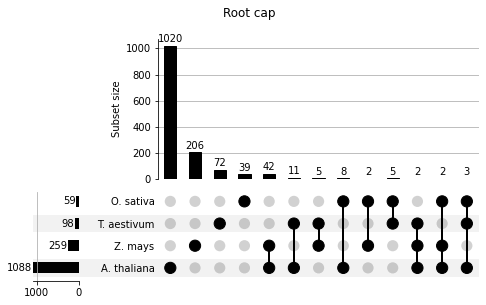

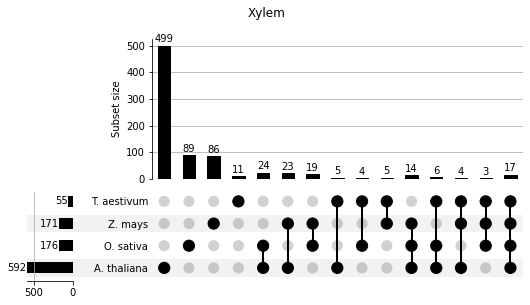

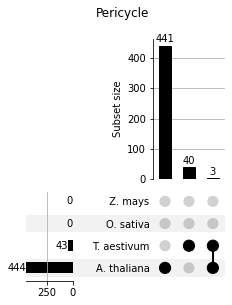

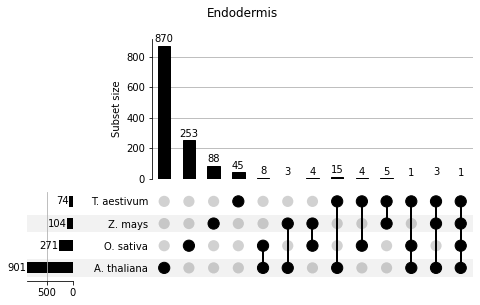

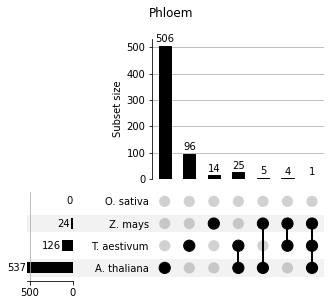

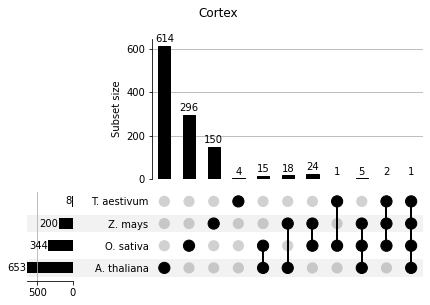

In [5]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

for orientation in ["vertical", "horizontal"]:
    for tissue in tissue_to_upset_input.keys():
        if tissue != "all_tissues":
            plot_result = plot(from_contents(tissue_to_upset_input[tissue]), show_counts=True, orientation=orientation)
            plot_result["intersections"].set_ylabel("Subset size")
            plt.suptitle("{}".format(tissue))#, fontproperties=arial_font, fontsize=13)
            plt.savefig("{}/{}_upset_DEGs_reprocessed_{}.svg".format(output_folder, tissue.replace(" ", "-"), orientation), format="svg")

## Aggregate all tissues together in one plot

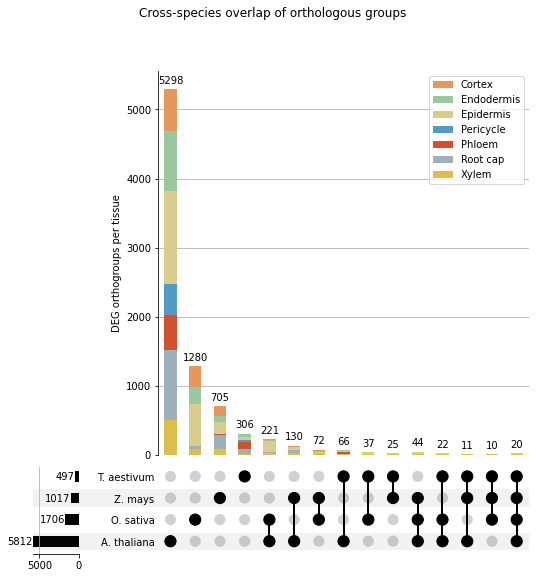

In [6]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

# Get the upset input dataframe for all the tissues combined
upset_input_all = from_contents(tissue_to_upset_input["all_tissues"])

# Add a tissue label to the matrix (for stacked bars)
upset_input_all["tissue"] = upset_input_all.id.str.split("_").str[0]

# Define the colors
tissue_colors = {
    "Endodermis": "#99c89e",
    "Epidermis":  "#d7ce8e",
    "Root cap":   "#9cb1ba",
    "Xylem":      "#ddbd4b",
    "Phloem":     "#d1502e",
    "Cortex":     "#e7965c",
    "Pericycle":  "#529cc3"
}

# Create the upset plot with stacked bars
upset = UpSet(upset_input_all, show_counts=True, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="DEG orthogroups per tissue", elements=16)
upset.plot()
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.savefig("{}/reprocessed_per_tissue_upset.svg".format(output_folder), format="svg")

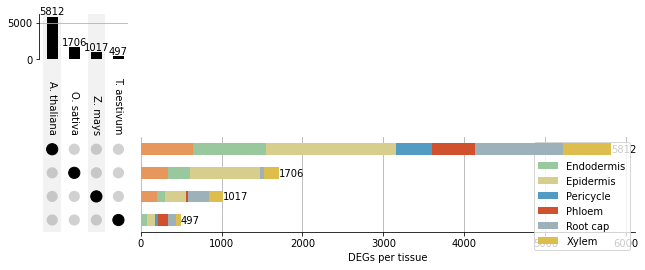

In [7]:
# Add a suffix to make the group IDs species specific (to get colored total species bars)
per_species_groups_dummy = dict()
for species, groups in tissue_to_upset_input["all_tissues"].items():
    per_species_groups_dummy[species] = {group+"_"+species for group in groups}

# Create the corresponding upset input dataframe
upset_input_all_dummy = from_contents(per_species_groups_dummy)

# Add a tissue label to the matrix
upset_input_all_dummy["tissue"] = upset_input_all_dummy.id.str.split("_").str[0]

# Plot vertical in order to take the stacked bars and replace the black bars on the plot above
upset = UpSet(upset_input_all_dummy, show_counts=True, orientation="vertical", intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(by="tissue", colors=tissue_colors, title="DEGs per tissue", elements=20)
upset.plot()
plt.savefig("{}/reprocessed_per_tissue_upset_extra_bars.svg".format(output_folder), format="svg")

## Plot overall conservation per tissue

### Prepare date for a conservation bar plot

In [8]:
# Arrange the input in a good format
species2tissue2genes_and_groups = extract_genes_and_orthogroups(species2df_dict, correspondance_dict)

# Arrange input 
tissue_to_upset_input = extract_tissue_groups(species2tissue2genes_and_groups)

In [9]:
# Initialize dataframe (similar to the upset input dataframe) including all tissues
upset_input_all = None

# Create input dataframes for each tissue
for tissue in tissue_to_upset_input.keys():
    
    # Get the upset input dataframe (to modify for the barplot)
    if tissue == "all_tissues":
        pass
    else:
        upset_input = from_contents(tissue_to_upset_input[tissue])
        
        # Add conservation (conserved in n species) as an integer under lowercase "conservation"
        upset_input["conservation"] = [sum(is_conserved) for is_conserved in list(upset_input.index)]
        
        # Add Conservation as a string under uppercase "Conservation"
        upset_input["Conservation"] = ["in {} species".format(sum(is_conserved)) for is_conserved in list(upset_input.index)]
        
        # Add tissue as column
        upset_input["Tissue"] = tissue
        
        # Concatenate the dataframes of all tissues into one
        if upset_input_all is None:
            upset_input_all = upset_input
        else:
            upset_input_all = pd.concat([upset_input_all, upset_input])

### Plot conservation bar plot

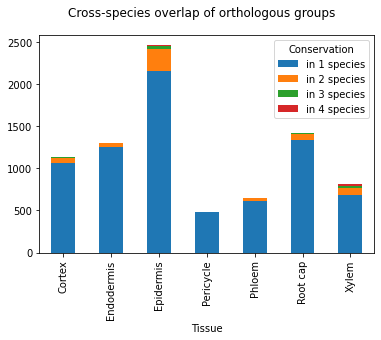

In [10]:
upset_input_all.groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.savefig("{}/reprocessed_per_tissue_barplot.svg".format(output_folder), format="svg")

### Plot conservation bar plot (only 2-4 species conservation)

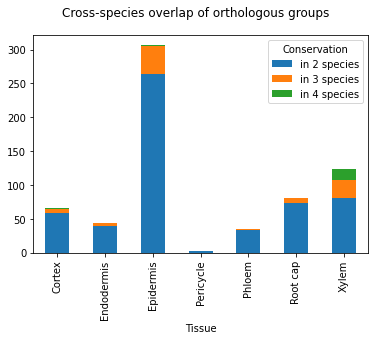

In [11]:
upset_input_all.query("conservation > 1").groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.savefig("{}/reprocessed_per_tissue_barplot_min_2_species.svg".format(output_folder), format="svg")

### Plot conservation bar plot (only 3-4 species conservation)

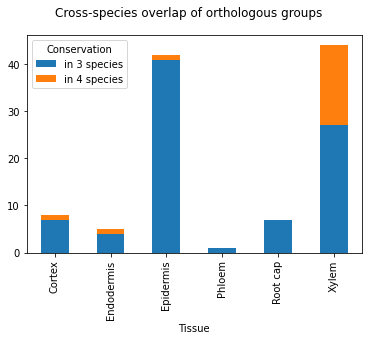

In [12]:
upset_input_all.query("conservation > 2").groupby(["Tissue", "Conservation"]).size().unstack(fill_value=0).plot.bar(stacked=True)
plt.suptitle("Cross-species overlap of orthologous groups".format(tissue))
plt.savefig("{}/reprocessed_per_tissue_barplot_min_3_species.svg".format(output_folder), format="svg")

## Write the underlying gene IDs to an Excel file

In [13]:
# Reverse the gene-to-group dict into a group-to-genes dict
species2group2genes_dict = reverse_gene_to_group_dict(species2gene2group_dict)

# Create the base dataframe with on each row a combination of species for a given tissue
upset_input = from_contents(tissue_to_upset_input["all_tissues"])
species_combination_df = pd.DataFrame(upset_input.index.unique().tolist(), columns=upset_input.index.names)
species_combination_df = species_combination_df.merge(pd.DataFrame(upset_input_all.Tissue.unique(), columns=["Tissue"]), how="cross")

In [14]:
with pd.ExcelWriter("{}/reprocessed_per_tissue_overlap_gene_IDs.xlsx".format(output_folder), engine="xlsxwriter") as writer:
    
    for species in species_combination_df.columns[:-1]: # the last column is the tissue
        
        # Initialize a dataframe to extend with the genes of a given species, using the base dataframe defined above
        species_combination_df_copy = species_combination_df.copy()
        
        # Initialize lists to store genes and orthogroups, to be added as columns
        genes_col = list()
        groups_col = list()
        
        # Loop over each species and tissue combination
        for i in species_combination_df_copy.index:
            
            # If the current species is included in the combination of species in this row
            if species_combination_df_copy.loc[i,species] == True:
                
                # Get the binary tuple of which species are present in the current row
                species_tuple = tuple(species_combination_df_copy.iloc[i,:-1])
                
                # Get the tissue of the current row
                tissue = species_combination_df_copy.iloc[i,-1]
                
                # Use the binary tuple as key to get the groups of a specific species combination, for a given tissue
                groups = set(upset_input_all.loc[species_tuple,:].query("Tissue == @tissue").id.str.split("_").str[1])

                # Convert groups into genes
                genes = set()
                for group in groups:
                    genes.update(species2group2genes_dict[species][group])
                    
                # Retain only genes that were in the original DEGs for that tissue
                genes = genes & species2tissue2genes_and_groups[species][tissue]["genes"]

                gene_list, group_list = list(genes), list(groups)

            else:
                gene_list, group_list = [""], [""]
            
            # Sort the genes and orthogroups alphabetically and combine them into a string
            gene_list.sort()
            group_list.sort()
            genes_col.append(", ".join(gene_list))
            groups_col.append(", ".join(group_list))
        
        # Add the genes and orthogroups as a column in the dataframe
        species_combination_df_copy["Genes"] = genes_col
        species_combination_df_copy["Orthogroups"] = groups_col
        
        # Write the final dataframe into an excel file, in a tab with the species name
        species_combination_df_copy.to_excel(writer, sheet_name=species, index=False)

### Example dataframe (in one Excel tab)

In [15]:
species_combination_df_copy

,A. thaliana,T. aestivum,O. sativa,Z. mays,Tissue,Genes,Orthogroups
0,True,False,False,False,Epidermis,,
1,True,False,False,False,Root cap,,
2,True,False,False,False,Xylem,,
3,True,False,False,False,Pericycle,,
4,True,False,False,False,Endodermis,,
...,...,...,...,...,...,...,...
100,False,False,False,True,Xylem,"Zm00001eb008440, Zm00001eb019860, Zm00001eb024...","ORTHO905GF000010, ORTHO905GF000197, ORTHO905GF..."
101,False,False,False,True,Pericycle,,
102,False,False,False,True,Endodermis,"Zm00001eb002780, Zm00001eb005780, Zm00001eb006...","ORTHO905GF000183, ORTHO905GF000221, ORTHO905GF..."
103,False,False,False,True,Phloem,"Zm00001eb019050, Zm00001eb031590, Zm00001eb054...","ORTHO905GF000005, ORTHO905GF000010, ORTHO905GF..."


## Rank marker genes across species

Setup: 
- The number of species for which a group is conserved will prioritize any other ranking. 
- Within each conservation level, orthogroups are ranked by taking the best ranked paralog within each species and then taking the mean over all species. 
- For each orthogroup, then also report the best marker gene of that group for each species.

Rationale:
- We want robust markers, so the level of conservation cross-species is the most important to take into account.
- We make use of ranks because they can be compared between experiments, while q-value or logFC can be biased due to differences in experimental setup.
- Within an orthogroup, multiple paralogs can be a marker gene. In the case of relatively big orthogroups, we might have only one gene in each species that is a very good marker gene, while others have a more diffuse signal. Averaging over all paralogs thus risks to mask the value of this one very good marker gene in each species. Therefore, it is better to take the best ranked paralog for each species.
- The mean of the best ranked paralogs over all species is taken, because the median is too unstable when there are at most only 4 ranks, and the geometric mean might give less weight to the ranks of wheat genes, simply because its ranks are higher because every marker occurs 3 times (hexaploid).

### Read in the DEG file for each species because we need the q-value and logFC

In [16]:
# Read in the input
species2df_dict = read_files(file_locs, sep=",")

# Get the top N orthogroup dataframes per tissue and species, with rank info
tissue_to_species_to_ranked_df = extract_ranked_orthogroups(species2df_dict, correspondance_dict)

### Format the output dataframe (rearrange and rename columns)

In [17]:
marker_ranking_df = upset_input_all.reset_index()
marker_ranking_df["Orthogroup"] = marker_ranking_df.id.str.split("_").str[-1]
marker_ranking_df = marker_ranking_df.drop(columns=["id", "Conservation"])
marker_ranking_df["Conservation"] = marker_ranking_df["conservation"]
marker_ranking_df = marker_ranking_df.drop(columns=["conservation"])
marker_ranking_df = marker_ranking_df.rename(columns={"Tissue": "Cell type"})

### Calculate an aggregate score within each orthogroup and add to the dataframe

In [18]:
# Initialize dictionaries to store the best marker genes and other marker genes for each species
species_to_best_marker = {species: list() for species in species2tissue2genes_and_groups.keys()}
species_to_other_markers = {species: list() for species in species2tissue2genes_and_groups.keys()}

# Initialize a list to store the mean of species ranks for each marker
mean_species_ranks = list()

# Loop over each (tissue-specific) marker orthogroup in the marker ranking dataframe
for i in marker_ranking_df.index:
    
    # Get the tissue and orthogroup for the current marker
    tissue = marker_ranking_df.loc[i,"Cell type"]
    group = marker_ranking_df.loc[i,"Orthogroup"]
    
    # Initialize a list to store the best ranks for the current marker across species
    best_ranks_per_species = list()
    
    # Loop over each species
    for species in species2tissue2genes_and_groups.keys():
        
        # If the current species is included in the combination of species in this row
        if marker_ranking_df.loc[i,species] == True:
            
            # Identify genes belonging to the current orthogroup and tissue, for the given species
            genes = species2group2genes_dict[species][group] & species2tissue2genes_and_groups[species][tissue]["genes"]
            
            # Get the dataframe of ranked genes for the current tissue and species
            df = tissue_to_species_to_ranked_df[tissue][species]
            
            # Filter the dataframe to include only the identified genes
            filtered_df = df[df["gene ID"].isin(genes)]
            
            # Find the gene with the best rank
            i_best = filtered_df["Rank"].idxmin()
            best_marker_gene = filtered_df.loc[i_best, "gene ID"]
            
            # Get the list of other marker genes sorted by rank, and convert to string
            other_marker_genes = list(filtered_df.sort_values(by="Rank", ascending=True)["gene ID"].astype(str))
            other_marker_genes = ""+(", ".join(other_marker_genes[1:]))
            
            # Get the best rank for the gene
            best_rank = filtered_df.loc[i_best, "Rank"]
            
            # Append the best rank to the list of best ranks for the current marker
            best_ranks_per_species.append(best_rank)
            
        else:
            best_marker_gene, other_marker_genes = "", ""
        
        # Add the best marker gene and other marker genes to their respective dictionaries
        species_to_best_marker[species].append(best_marker_gene)
        species_to_other_markers[species].append(other_marker_genes)
    
    # Calculate the mean of the best ranks for the current marker across species
    mean_species_ranks.append(mean(best_ranks_per_species))

# Add the mean ranks to the marker ranking dataframe as a new column "Score"
marker_ranking_df["Score"] = mean_species_ranks

# Add the Arabidopsis gene aliases
marker_ranking_df["Ath best marker alias"] = [gene_to_alias_dict[marker] if marker in gene_to_alias_dict else marker for marker in species_to_best_marker["A. thaliana"]]

# Add the wheat subgenome stability
marker_ranking_df["Wheat subgenome stability"] = [gene_to_stability_dict[marker] if marker in gene_to_stability_dict else "" for marker in species_to_best_marker["T. aestivum"]]

# Add the wheat subgenome specificity
marker_ranking_df["Wheat subgenome specificity"] = [gene_to_specificity_dict[marker] if marker in gene_to_specificity_dict else "" for marker in species_to_best_marker["T. aestivum"]]

### Add final ranking to the dataframe and write results to Excel file

In [19]:
with pd.ExcelWriter("{}/reprocessed_cross_species_markers.xlsx".format(output_folder), engine='xlsxwriter') as writer:
    
    for species in species2tissue2genes_and_groups.keys():
        
        # Initialize a dataframe to extend with the genes of a given species, using the base dataframe defined above
        marker_ranking_df_copy = marker_ranking_df.copy()
        
        # Add the best marker and all the other markers for one orthogroup as two columns in the dataframe
        marker_ranking_df_copy["Best marker"] = species_to_best_marker[species]
        marker_ranking_df_copy["Other markers"] = species_to_other_markers[species]
        
        # Sort the marker orthogroups on the score
        marker_ranking_df_copy = marker_ranking_df_copy.sort_values(by=["Conservation", "Score"], ascending=[False, True])

        # Convert scores to ranks
        marker_ranking_df_copy["Score"] = range(1,marker_ranking_df_copy.shape[0]+1)
        marker_ranking_df_copy = marker_ranking_df_copy.rename(columns={"Score": "Rank"})
        
        # Write the final dataframe into an excel file, in a tab with the species name
        marker_ranking_df_copy.to_excel(writer, sheet_name=species, index=False)

### Example dataframe (in one Excel tab)

In [20]:
marker_ranking_df_copy

,A. thaliana,T. aestivum,O. sativa,Z. mays,Cell type,Orthogroup,Conservation,Rank,Ath best marker alias,Wheat subgenome stability,Wheat subgenome specificity,Best marker,Other markers
7629,True,True,True,True,Cortex,ORTHO905GF000160,4,1,DRN1,stable,specific,Zm00001eb429540,"Zm00001eb023070, Zm00001eb249760, Zm00001eb429..."
4097,True,True,True,True,Xylem,ORTHO905GF006895,4,2,VRLK1,NaN,NaN,Zm00001eb015720,
3972,True,True,True,True,Xylem,ORTHO905GF003247,4,3,XCP1,NaN,NaN,Zm00001eb267050,Zm00001eb362260
4249,True,True,True,True,Xylem,ORTHO905GF000851,4,4,TBL33,NaN,NaN,Zm00001eb062390,
3925,True,True,True,True,Xylem,ORTHO905GF007961,4,5,IQD13,NaN,NaN,Zm00001eb365750,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,True,False,False,False,Epidermis,ORTHO905GF010869,1,8243,AtCPB,,,,
1124,True,False,False,False,Epidermis,ORTHO905GF006502,1,8244,AT4G10140,,,,
714,True,False,False,False,Epidermis,ORTHO905GF006454,1,8245,ATMT-1,,,,
223,True,False,False,False,Epidermis,ORTHO905GF003402,1,8246,VHA-E3,,,,
